In [1]:
from drone_detector.utils import * 
from drone_detector.imports import *
import rasterio.mask as rio_mask
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")
sys.path.append('..')
from src.tree_functions import *

# Comparison of plot characteristics and digitized deadwood

## Hiidenportti

Read data and do some wrangling.

In [3]:
field_data_path = Path('../data/hiidenportti')
anns = gpd.read_file('../../data/raw/hiidenportti/virtual_plots/all_deadwood_hiidenportti.geojson')
plot_circles = gpd.read_file(field_data_path/'plot_circles.geojson')
field_data = pd.read_csv(field_data_path/'all_plot_data.csv')
virtual_plot_grid = gpd.read_file(field_data_path/'envelopes_with_trees.geojson')
natura_areas = gpd.read_file(field_data_path/'hiidenportti_natura.geojson')

Filter plot circles so that only those present in virtual plots remain.

In [4]:
plot_circles['in_vplot'] = plot_circles.apply(lambda row: 1 if any(virtual_plot_grid.geometry.contains(row.geometry)) 
                                              else 0, axis=1)
plot_circles['id'] = plot_circles['id'].astype(int)
field_data = field_data[field_data.id.isin(plot_circles[plot_circles.in_vplot==1].id.unique())]
field_data.rename(columns= {c: c.replace('.','_') for c in field_data.columns}, inplace=True)
dw_cols = ['id'] + [c for c in field_data.columns if 'dw' in c]
plot_dw_data = field_data[dw_cols].copy()

In [5]:
plot_circles = plot_circles[plot_circles.in_vplot == 1]

In [6]:
tot_vplot_area = virtual_plot_grid.area.sum()
tot_cons_area = natura_areas.area.sum()
tot_man_area = tot_vplot_area - tot_cons_area
tot_man_area / 10000, tot_cons_area / 10000

(34.50055023464537, 21.718123155322758)

Convert `n_dw` (number of deadwood stems per hectare), `n_ddw` and `n_udw` to signify number of deadwood stems in circular plot with 9m radius.

In [7]:
plot_dw_data['n_dw_plot'] = np.round((plot_dw_data['n_dw']/10000)*np.pi*9**2).astype(int)
plot_dw_data['n_ddw_plot'] = np.round((plot_dw_data['n_ddw']/10000)*np.pi*9**2).astype(int)
plot_dw_data['n_udw_plot'] = plot_dw_data.n_dw_plot - plot_dw_data.n_ddw_plot

In [8]:
def match_circular_plot(row, plots):
    "Match annotations with field plots"
    for p in plots.itertuples():
        if row.geometry.intersects(p.geometry):
            return int(p.id)

In [9]:
anns['plot_id'] = anns.apply(lambda row: match_circular_plot(row, plot_circles), axis=1)
anns_in_plots = anns[anns.geometry.intersects(plot_circles.geometry.unary_union)].copy()
anns_in_plots['plot_id'] = anns_in_plots.plot_id.astype(int)

Count the number of annotated deadwood instances in each circular field plot, as well as note which of the circular plots are located in the conserved areas.

In [10]:
plot_dw_data['n_dw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots.plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots.plot_id.unique() else 0, axis=1)
plot_dw_data['n_ddw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[anns_in_plots.groundwood==2].plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots[anns_in_plots.groundwood==2].plot_id.unique() else 0, axis=1)
plot_dw_data['n_udw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[anns_in_plots.groundwood==1].plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots[anns_in_plots.groundwood==1].plot_id.unique() else 0, axis=1)
plot_dw_data['geometry'] = plot_dw_data.apply(lambda row: plot_circles[plot_circles.id == row.id].geometry.iloc[0], 
                                              axis=1)
plot_dw_data = gpd.GeoDataFrame(plot_dw_data, crs=plot_circles.crs)
plot_dw_data['conservation'] = plot_dw_data.apply(lambda row: 1 if any(natura_areas.geometry.contains(row.geometry))
                                                  else 0, axis=1)

In [11]:
plot_dw_data.pivot_table(index='conservation', values=['n_ddw_plot', 'n_udw_plot', 'n_ddw_ann', 'n_udw_ann'], 
                         aggfunc='sum', margins=True)

,n_ddw_ann,n_ddw_plot,n_udw_ann,n_udw_plot
conservation,,,,
0,202,162,35,51
1,94,158,24,50
All,296,320,59,101


Get plot-wise canopy cover percentage based on LiDAR derived canopy height model as the percentage of plot area with height more than 2 meters.

In [12]:
pcts = []

with rio.open('../../data/raw/hiidenportti/full_mosaics/CHM_Hiidenportti_epsg.tif') as src:
    crs = src.crs
    for row in plot_dw_data.itertuples():
        plot_im, plot_tfm = rio_mask.mask(src, [row.geometry], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])

In [13]:
plot_dw_data['canopy_cover_pct'] = pcts

In [14]:
pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['canopy_cover_pct'],
               aggfunc=['min', 'max', 'mean', 'std', 'count'], margins=True)

,min,max,mean,std,count
,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct
conservation,,,,,
0,0.142006,0.947162,0.569170,0.188720,44
1,0.083333,0.866601,0.669340,0.163097,27
All,0.083333,0.947162,0.607263,0.184815,71


Plot the relationship between annotated deadwood and field-measured deadwood. The darker a single dot is, the more plots are located in that point.

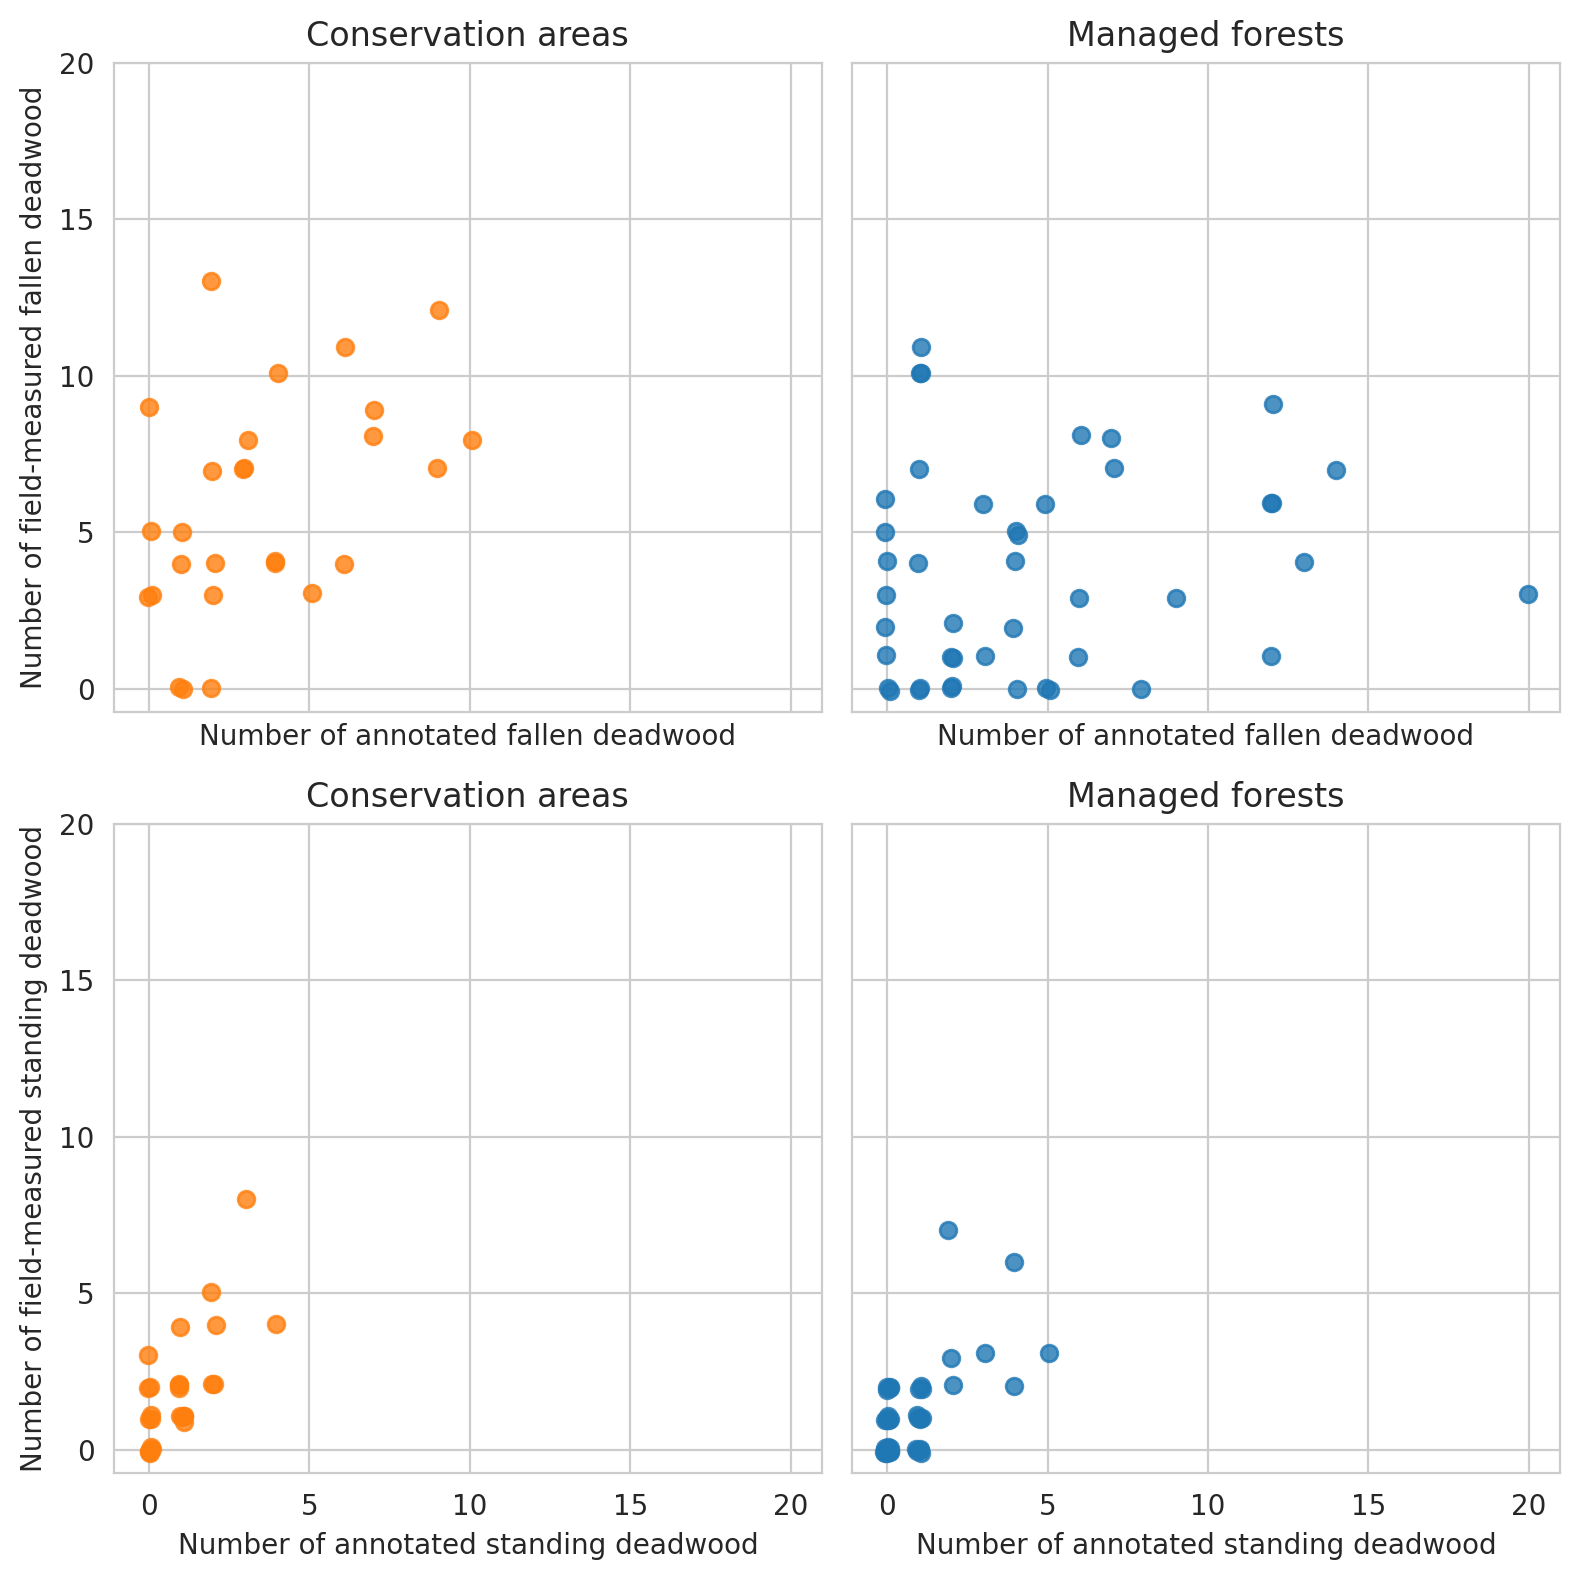

In [15]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
plt.tight_layout()
plt.savefig('../data/figures/hiidenportti_dist.jpeg', dpi=300, bbox_inches='tight')

Read individual tree measurements, and convert `l` from decimeters to meters.

In [16]:
tree_data = pd.read_csv(field_data_path/'hiidenportti_singletree.csv')
tree_data = tree_data[tree_data.plot_id.isin(plot_dw_data.id.unique())]
tree_data['l'] /= 10

Add information about conservation area to tree data.

In [17]:
tree_data['conservation'] = tree_data.apply(lambda row: plot_dw_data[plot_dw_data.id == row.plot_id].conservation.unique()[0], axis=1)

For annotated groundwood, as the annotations can be twisted due to e.g. orthorectification errors, we use the longest side of the smallest rotated rectangle that can be fit around the polygon as a proxy for the trunk length.

Diameter can be approximated with the following approach. For each polygon,

1. Get minimum rotated rectangle 
2. Draw three lines that are perpendicular to the longer side of the minimum rotated rectangle, starting from the points of 10%, 50% and 90% of the length of the minimum rotated rectangle 
3. Intersect these lines with the polygon. Diameter is the mean lenght of these intersecting lines.

This is not the same as DBH, but close enough.

In [18]:
anns_in_plots['tree_length'] = anns_in_plots.apply(lambda row: get_len_in_plot(row.geometry, plot_circles), axis=1)

Compare the distributions of the downed trunk lengths. Both graphs only take the parts within the plots into account. Lengths are binned into 1m bins.

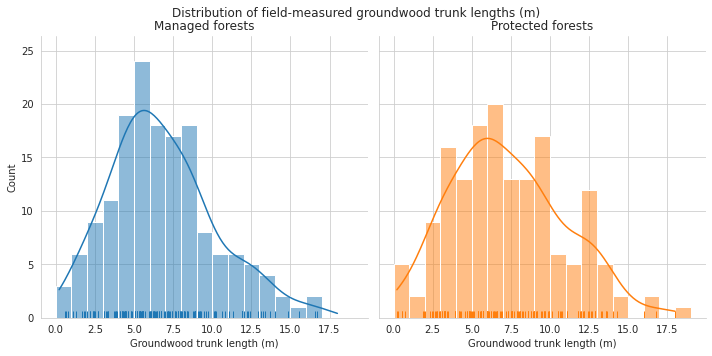

In [19]:
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.l > 0)], x='l', 
                hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False, binwidth=1, binrange=(0, max(tree_data[tree_data.tree_class == 4].l))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

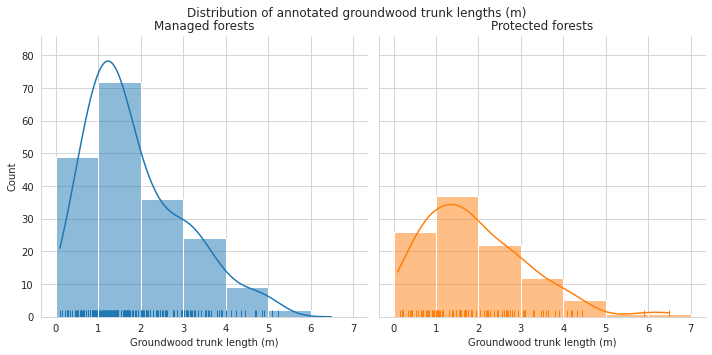

In [20]:
g = sns.displot(data=anns_in_plots[anns_in_plots.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(anns_in_plots.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

As expected, annotated trunks are clearly on average shorter than field measured.

Compare the measured DBH for downed trees and estimated diameter of annotated downed deadwood. For annotated deadwood, the diameter is estimated for the whole tree, not only for the part within the field plot. DBHs are binned into 50mm bins.

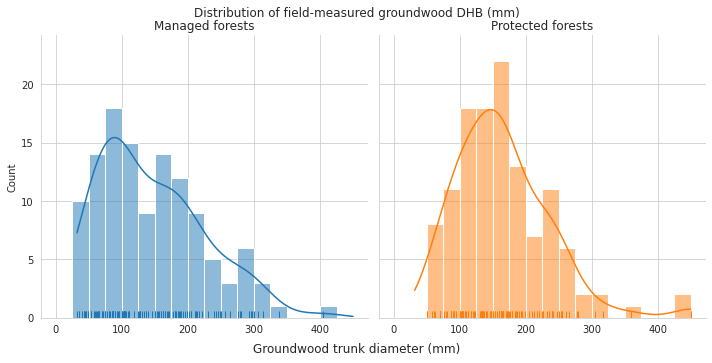

In [21]:
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.dbh>0)], x='dbh', hue='conservation', 
                col='conservation', kde=True, rug=True, legend=False, binwidth=25,
                binrange=(0, max(tree_data[(tree_data.tree_class == 4)].dbh))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

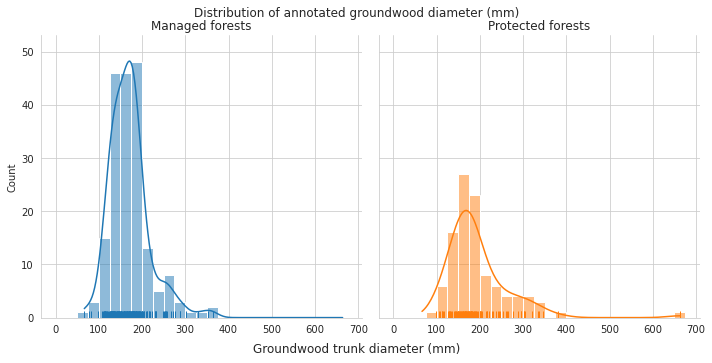

In [22]:
anns_in_plots['diam'] = anns_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=anns_in_plots[(anns_in_plots.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(anns_in_plots[(anns_in_plots.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

In [89]:
pd.pivot_table(data=tree_data[(tree_data.tree_class == 4)&(tree_data.dbh>0)],
               index=['conservation'], values=['l', 'dbh'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean           min            max      
                     dbh         l dbh         l  dbh     l
conservation                                               
0             145.208333  6.883454  32  0.800000  404  16.7
1             165.115702  7.506937  51  1.866795  450  16.8
All           155.203320  7.196489  32  0.800000  450  16.8

In [90]:
pd.pivot_table(data=anns_in_plots[anns_in_plots.groundwood==2], index=['conservation'], values=['tree_length', 'diam'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean                    min                     max  \
                    diam tree_length       diam tree_length        diam   
conservation                                                              
0             170.938241    1.846633  66.441891    0.095362  363.225700   
1             194.754016    1.920715  97.691220    0.149797  663.718899   
All           179.305946    1.872662  66.441891    0.095362  663.718899   

                          
             tree_length  
conservation              
0               5.225743  
1               6.485503  
All             6.485503

In [25]:
plot_dw_data['n_dw_stand_field'] = plot_dw_data.apply(lambda row: len(tree_data[(tree_data.plot_id == row.id) &
                                                                                (tree_data.tree_class == 3)]),
                                                      axis=1)
plot_dw_data['n_dw_fall_field'] = plot_dw_data.apply(lambda row: len(tree_data[(tree_data.plot_id == row.id) &
                                                                               ((tree_data.tree_class == 4)|
                                                                                (tree_data.tree_class == 5))]),
                                                     axis=1)
plot_dw_data['n_dw_tot_field'] = plot_dw_data.n_dw_stand_field + plot_dw_data.n_dw_fall_field

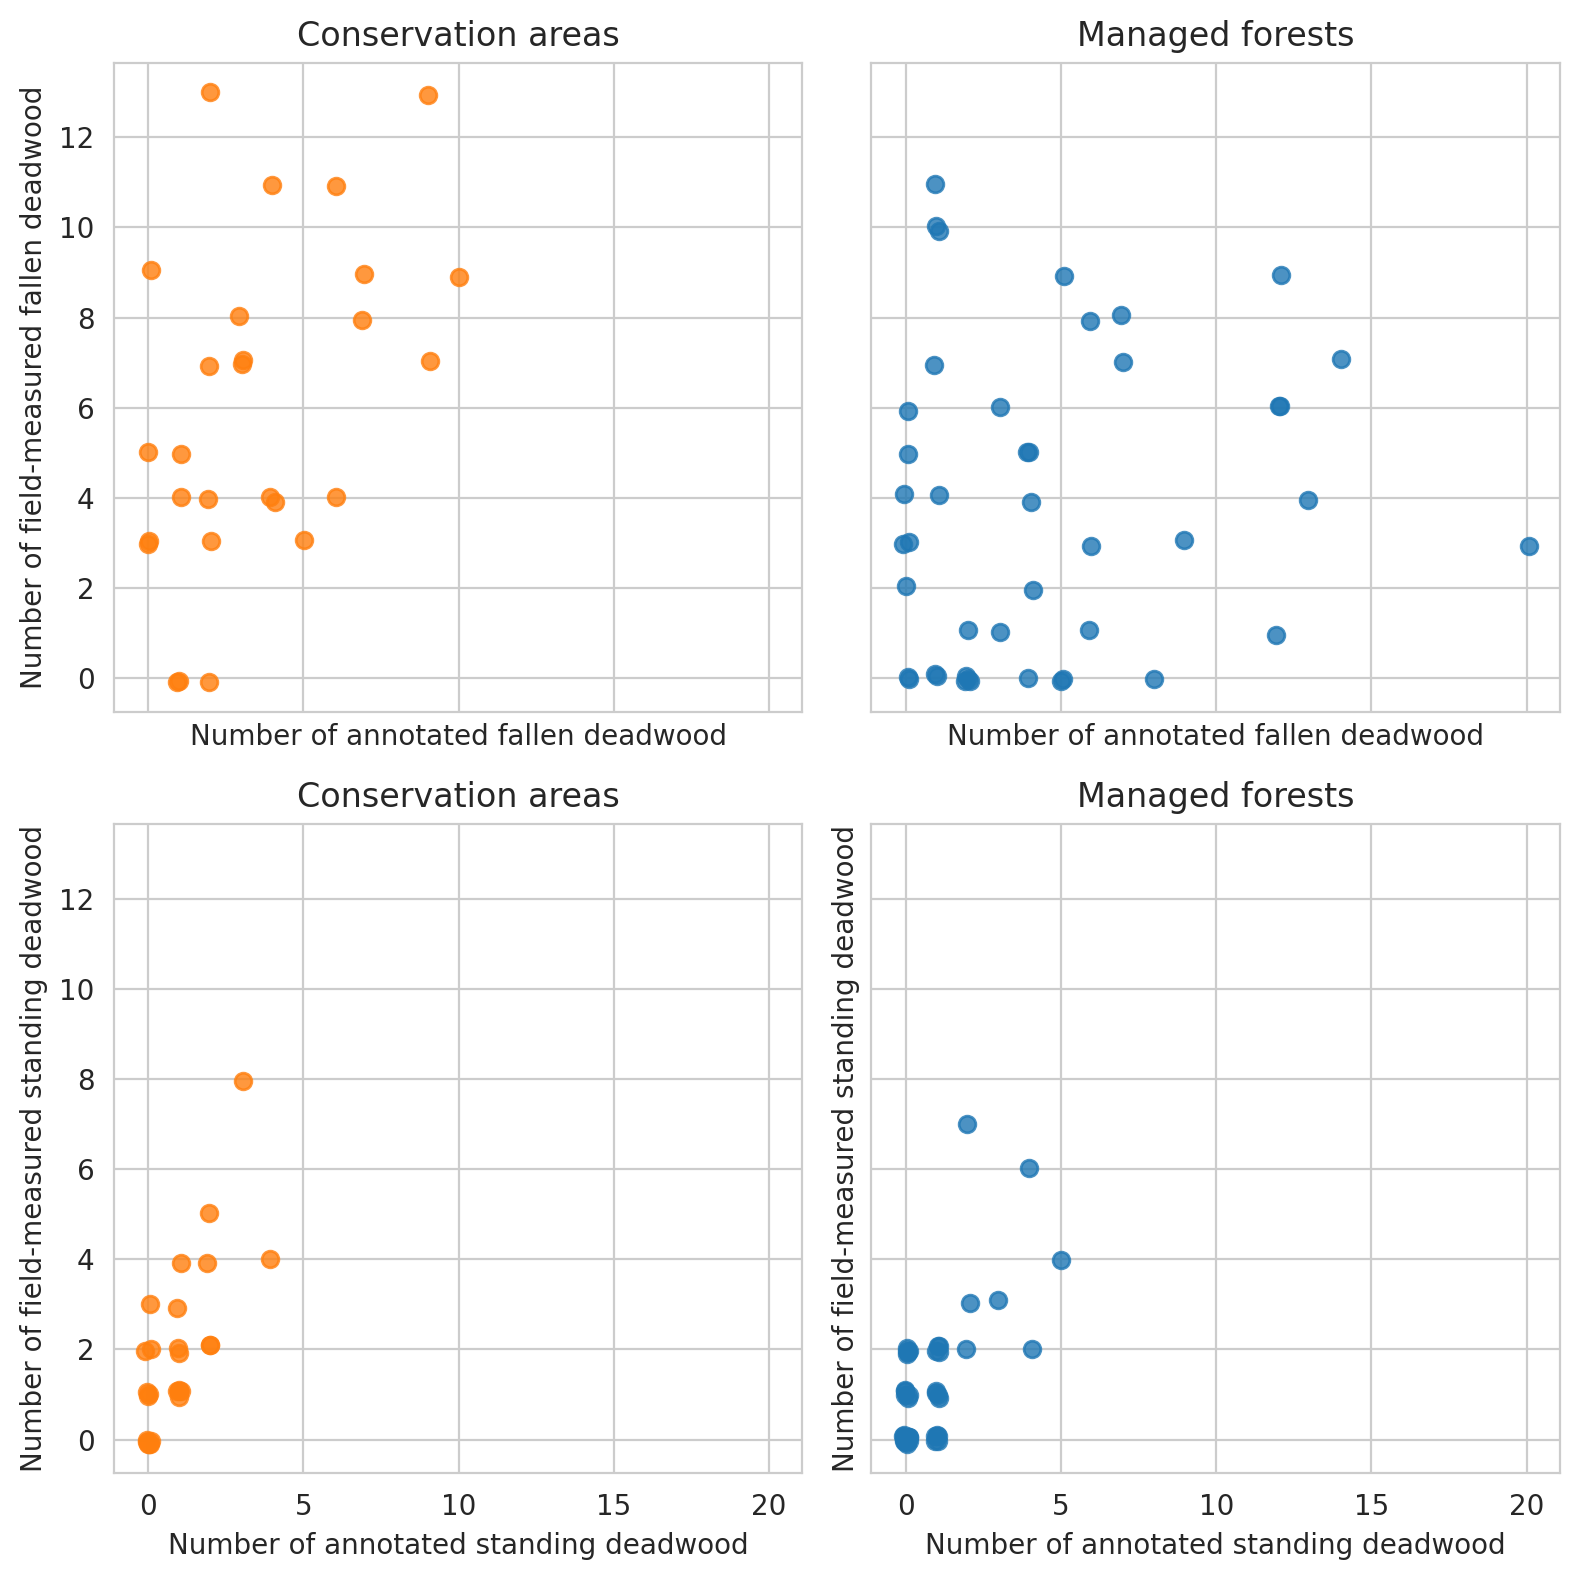

In [26]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_dw_fall_field', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_dw_fall_field', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel(None)


sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_dw_stand_field', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')

sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_dw_stand_field', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('Number of field-measured standing deadwood')
plt.tight_layout()

Plot the total lengths of groundwood located within a single field plot.

In [27]:
plot_dw_data['l_gw_field'] = plot_dw_data.apply(lambda row: tree_data[(tree_data.plot_id == row.id) &
                                                                      (tree_data.tree_class == 4)].l.sum()
                                              , axis=1)
plot_dw_data['l_gw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                        (anns_in_plots.layer == 'groundwood')
                                                                       ].tree_length.sum()
                                              , axis=1)

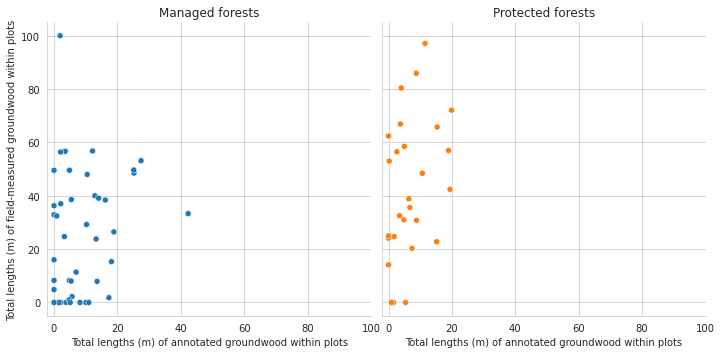

In [28]:
g = sns.relplot(data=plot_dw_data, x='l_gw_ann', y='l_ddw', col='conservation', hue='conservation', alpha=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(range(0,101,20))
g.axes[0,0].set_xticks(range(0,101,20))
g.axes[0,1].set_xticks(range(0,101,20))
g.set_ylabels('Total lengths (m) of field-measured groundwood within plots')
g.set_xlabels('Total lengths (m) of annotated groundwood within plots')
plt.show()

In [29]:
import scipy as sp
from functools import partial
def ann(data, **kws):
    r, p = sp.stats.pearsonr(data[kws['x_col']], data[kws['y_col']])
    ax = plt.gca()
    ax.text(.8, .1, 'r={:.2f}\np={:.2g}'.format(r, p),
            transform=ax.transAxes)

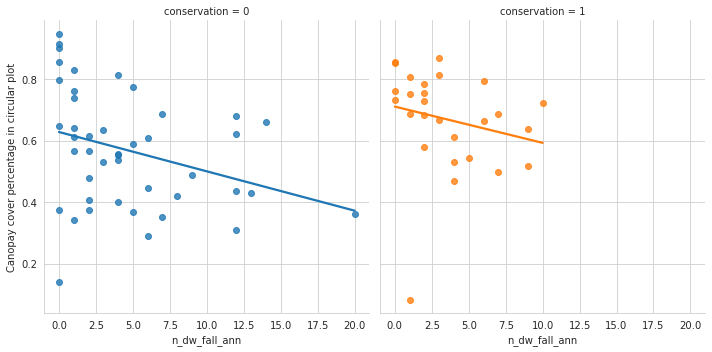

In [30]:
g = sns.lmplot(data=plot_dw_data, x='n_ddw_ann', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopay cover percentage in circular plot')
g.set_xlabels('n_dw_fall_ann')
#g.map_dataframe(ann, **{'x_col':'n_ddw_ann', 'y_col':'canopy_cover_pct'})

Plot the difference in the numbers of annotated deadwood.

In [31]:
plot_dw_data['n_ddw_plot_diff'] = plot_dw_data.n_ddw_plot - plot_dw_data.n_ddw_ann

In [32]:
plot_dw_data['n_udw_plot_diff'] = plot_dw_data.n_udw_plot - plot_dw_data.n_udw_ann

Text(0.5, 1.0, 'Conserved forests')

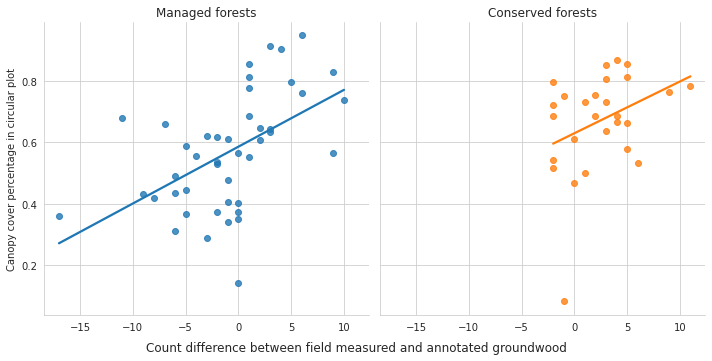

In [33]:
g = sns.lmplot(data=plot_dw_data, x='n_ddw_plot_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Count difference between field measured and annotated groundwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

Text(0.5, 1.0, 'Conserved forests')

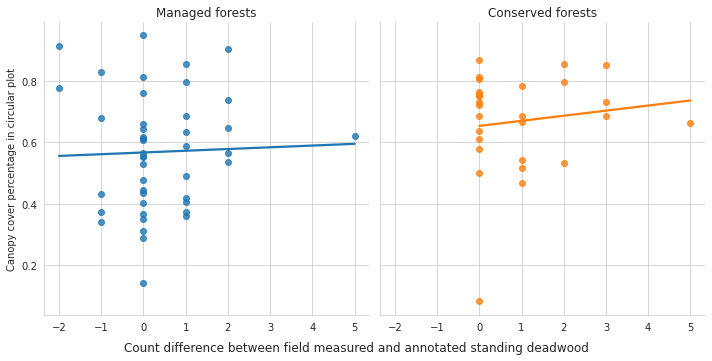

In [34]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_plot_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Count difference between field measured and annotated standing deadwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

In [35]:
plot_dw_data['l_udw_mean'] = plot_dw_data.apply(lambda row: tree_data[(tree_data.plot_id==row.id)&
                                                                 (tree_data.tree_class==3)].l.mean(), axis=1)
plot_dw_data['d_udw_mean'] = plot_dw_data.apply(lambda row: tree_data[(tree_data.plot_id==row.id)&
                                                                 (tree_data.tree_class==3)].dbh.mean(), axis=1)
plot_dw_data['l_udw_mean'].fillna(value=0, inplace=True)
plot_dw_data['d_udw_mean'].fillna(value=0, inplace=True)


Text(0.5, 1.0, 'Conserved forests')

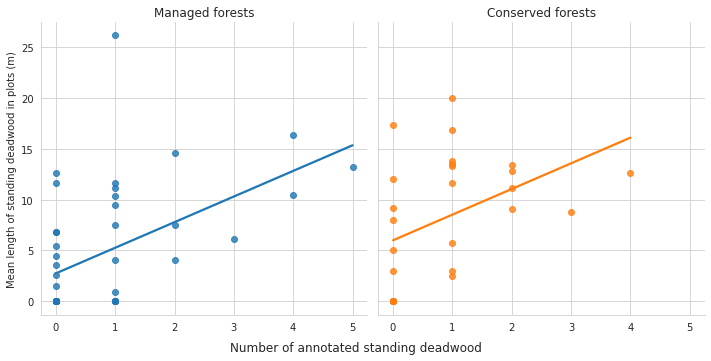

In [36]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_ann', y='l_udw_mean', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Mean length of standing deadwood in plots (m)')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Number of annotated standing deadwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

Text(0.5, 1.0, 'Conserved forests')

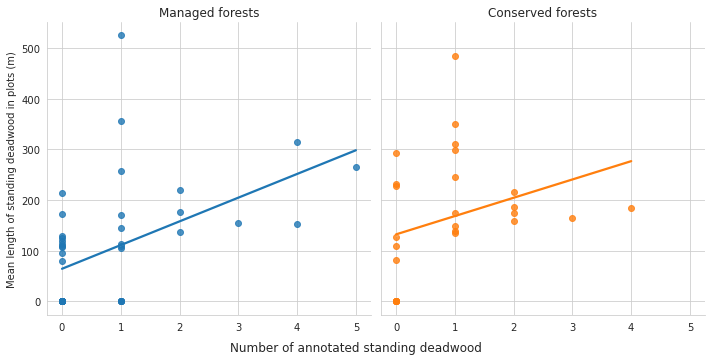

In [37]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_ann', y='d_udw_mean', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Mean length of standing deadwood in plots (m)')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Number of annotated standing deadwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

Text(0.5, 1.0, 'Conserved forests')

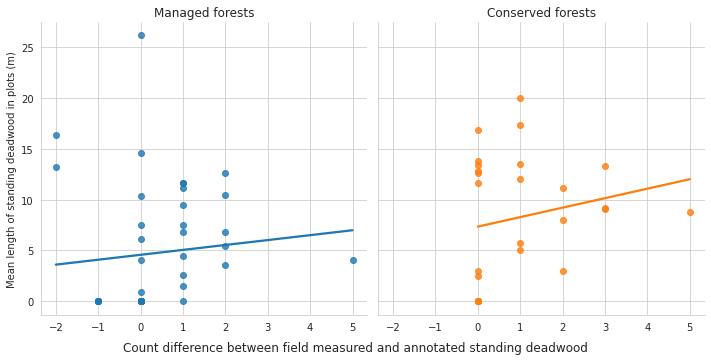

In [38]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_plot_diff', y='l_udw_mean', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Mean length of standing deadwood in plots (m)')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Count difference between field measured and annotated standing deadwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

Text(0.5, 1.0, 'Conserved forests')

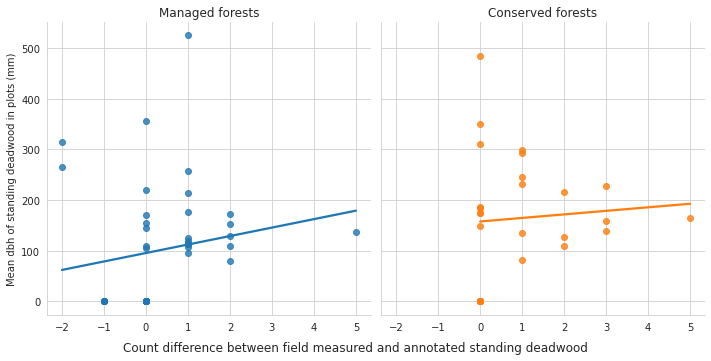

In [39]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_plot_diff', y='d_udw_mean', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Mean dbh of standing deadwood in plots (mm)')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Count difference between field measured and annotated standing deadwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

In [40]:
plot_dw_data['l_dw_plot_diff'] = plot_dw_data.l_ddw - plot_dw_data.l_gw_ann

Relation between canopy cover percentage and total lengths of groundwood in field plots.

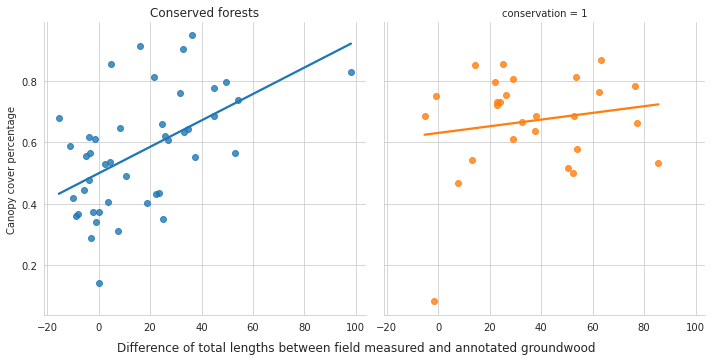

In [41]:
g = sns.lmplot(data=plot_dw_data, x='l_dw_plot_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Difference of total lengths between field measured and annotated groundwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][0].set_title('Conserved forests')

#g.map_dataframe(ann, **{'x_col':'l_dw_plot_diff', 'y_col':'canopy_cover_pct'})
plt.show()

In [42]:
anns_in_plots['v_ddw'] = anns_in_plots.geometry.apply(cut_cone_volume)

In [43]:
plot_dw_data['v_ddw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                        (anns_in_plots.layer == 'groundwood')
                                                                       ].v_ddw.sum()
                                              , axis=1)

In [44]:
plot_dw_data['v_dw_plot'] = (plot_dw_data['v_dw']/10000)*np.pi*9**2
plot_dw_data['v_ddw_plot'] = (plot_dw_data['v_ddw']/10000)*np.pi*9**2
plot_dw_data['v_udw_plot'] = plot_dw_data.v_dw_plot - plot_dw_data.v_ddw_plot

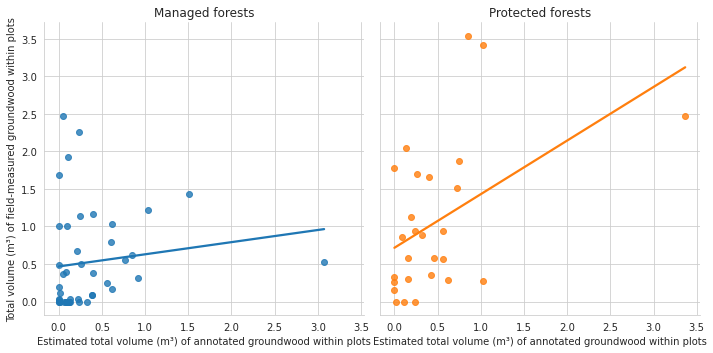

In [45]:
g = sns.lmplot(data=plot_dw_data, x='v_ddw_ann', y='v_ddw_plot', col='conservation', hue='conservation', #alpha=.8,
                legend=False, ci=0)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(np.arange(0,4,.5))
g.axes[0,0].set_xticks(np.arange(0,4,.5))
g.axes[0,1].set_xticks(np.arange(0,4,.5))
g.set_ylabels('Total volume (m³) of field-measured groundwood within plots')
g.set_xlabels('Estimated total volume (m³) of annotated groundwood within plots')
plt.show()

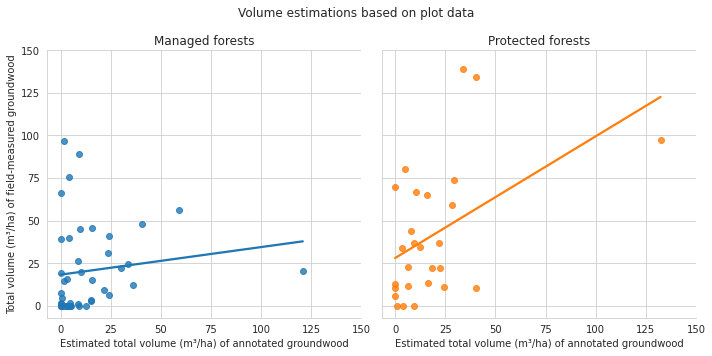

In [46]:
plot_dw_data['v_ddw_ann_ha'] = (10000 * plot_dw_data.v_ddw_ann) / (np.pi * 9**2)
g = sns.lmplot(data=plot_dw_data, x='v_ddw_ann_ha', y='v_ddw', col='conservation', hue='conservation', ci=0,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(range(0,151,25))
g.axes[0,0].set_xticks(range(0,151,25))
g.axes[0,1].set_xticks(range(0,151,25))
g.set_ylabels('Total volume (m³/ha) of field-measured groundwood')
g.set_xlabels('Estimated total volume (m³/ha) of annotated groundwood')
plt.suptitle('Volume estimations based on plot data')
plt.tight_layout()
plt.show()

In [47]:
pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw
conservation,,,,,,
0,0.0,96.868379,20.529026,10.797590,25.628214,44
1,0.0,139.171786,41.311932,33.717269,38.785210,27
All,0.0,139.171786,28.432385,15.575737,32.641219,71


In [48]:
pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw_ann_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha
conservation,,,,,,
0,0.0,120.729684,13.470250,5.076398,21.088238,44
1,0.0,132.315880,18.485042,10.424918,25.867510,27
All,0.0,132.315880,15.377284,8.862164,22.972285,71


In [49]:
plot_dw_data['v_ddw_diff'] = plot_dw_data.v_ddw - plot_dw_data.v_ddw_ann_ha

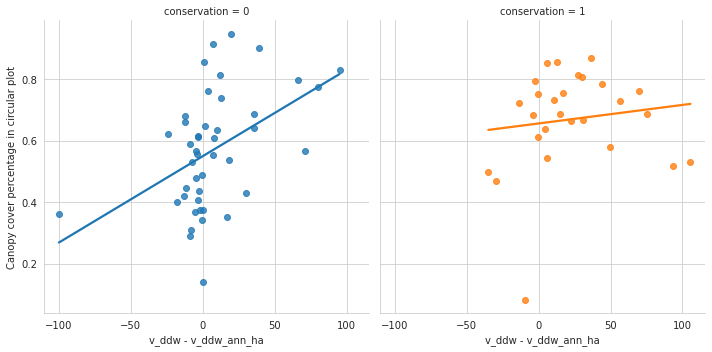

In [50]:
g = sns.lmplot(data=plot_dw_data, x='v_ddw_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('v_ddw - v_ddw_ann_ha')


## Sudenpesänkangas

Read data and do some wrangling.

In [51]:
evo_fd_path = Path('../data/sudenpesankangas/')
evo_anns = gpd.read_file('../../data/raw/sudenpesankangas/virtual_plots/sudenpesankangas_deadwood.geojson')
evo_anns = evo_anns.to_crs('epsg:3067')
evo_plot_circles = gpd.read_file(evo_fd_path/'plot_circles.geojson')
evo_plot_circles['id'] = evo_plot_circles['id'].astype(int)
evo_natura = gpd.read_file(evo_fd_path/'sudenpesankangas_natura.geojson')
evo_field_data = pd.read_csv(evo_fd_path/'puutiedot_sudenpesänkangas.csv', sep=';', decimal=',')
evo_field_data = gpd.GeoDataFrame(evo_field_data, geometry=gpd.points_from_xy(evo_field_data.gx, evo_field_data.gy), 
                                   crs='epsg:3067')
evo_grid = gpd.read_file(evo_fd_path/'vplots.geojson')
evo_grid = evo_grid.to_crs('epsg:3067')
evo_field_data['plotid'] = evo_field_data.kaid + 1000
evo_field_data = evo_field_data[evo_field_data.puuluo.isin([3,4])]

In [52]:
def match_plotid_spk(geom, plots):
    for r in plots.itertuples():
        if r.geometry.contains(geom):
            return r.id
    return None

In [53]:
evo_plots_updated = pd.read_csv(evo_fd_path/'Koealatunnukset_Evo_2018.txt', sep=' ')
evo_plots_luke = pd.read_csv(evo_fd_path/'Koealatunnukset_Evo_2018_LUKE.txt', sep=' ')
evo_plots_updated = gpd.GeoDataFrame(evo_plots_updated, geometry=gpd.points_from_xy(evo_plots_updated.x,
                                                                                    evo_plots_updated.y),
                                     crs='epsg:3067')
evo_plots_luke = gpd.GeoDataFrame(evo_plots_luke, geometry=gpd.points_from_xy(evo_plots_luke.x,
                                                                              evo_plots_luke.y),
                                     crs='epsg:3067')
evo_plots = pd.concat([evo_plots_updated, evo_plots_luke])
evo_plots.rename(columns= {c: c.replace('.','_') for c in evo_plots.columns}, inplace=True)

In [54]:
evo_plots['spk_id'] = evo_plots.geometry.apply(lambda row: match_plotid_spk(row, evo_plot_circles))

In [55]:
evo_plots.dropna(subset='spk_id', inplace=True)

In [56]:
evo_plots['geometry'] = evo_plots.spk_id.apply(lambda row: evo_plot_circles[evo_plot_circles.id == row].geometry.iloc[0])

In [57]:
evo_plots.drop(columns=['id'], inplace=True)
evo_plots.rename(columns={'spk_id': 'id'}, inplace=True)

In [58]:
evo_plots['conservation'] = evo_plots.geometry.apply(lambda row: 1 if evo_natura.geometry.unary_union.intersects(row)
                                                     else 0)

In [59]:
evo_anns['plot_id'] = evo_anns.apply(lambda row: int(row.vplot_id.split('_')[1]), axis=1)

In [60]:
evo_plots = evo_plots[evo_plots.id.isin(evo_anns.plot_id.unique())]

In [61]:
evo_anns['plot_id'] = evo_anns.apply(lambda row: match_circular_plot(row, evo_plots), axis=1)
evo_anns = evo_anns[evo_anns.geometry.intersects(evo_plots.geometry.unary_union)].copy()

In [62]:
evo_tot_vplot_area = evo_grid.area.sum()

In [63]:
evo_cons_area = evo_natura.overlay(evo_grid).area.sum()

In [64]:
evo_man_area = evo_tot_vplot_area - evo_cons_area

In [65]:
evo_man_area / 10000, evo_cons_area / 10000

(13.737872561979806, 57.262127438000405)

Add canopy density based on LiDAR derived canopy height model. The density is the percentage of field plot area with height above 2 meters.

In [66]:
pcts = []

with rio.open('../../data/raw/sudenpesankangas/full_mosaics/sudenpesankangas_chm.tif') as src:
    for row in evo_plots.itertuples():
        plot_im, plot_tfm = rio_mask.mask(src, [row.geometry], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])

In [67]:
evo_plots['canopy_cover_pct'] = pcts

In [68]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['canopy_cover_pct'],
               aggfunc=['min', 'max', 'mean', 'std', 'count'], margins=True)

,min,max,mean,std,count
,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct
conservation,,,,,
0,0.237288,0.959839,0.676011,0.264467,14
1,0.491036,0.991992,0.853076,0.113649,57
All,0.237288,0.991992,0.818162,0.168393,71


Count the number of deadwood instances similarly as for Hiidenportti data and plot the relationship between them.

In [69]:
evo_plots['n_dw_ann'] = evo_plots.apply(lambda row: evo_anns.plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns.plot_id.unique() else 0, axis=1)
evo_plots['n_ddw_ann'] = evo_plots.apply(lambda row: evo_anns[evo_anns.label=='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns[evo_anns.label=='groundwood'].plot_id.unique() else 0, axis=1)
evo_plots['n_udw_ann'] = evo_plots.apply(lambda row: evo_anns[evo_anns.label!='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns[evo_anns.label!='groundwood'].plot_id.unique() else 0, axis=1)

evo_plots['n_dw_plot'] = np.round((evo_plots['n_dw']/10000)*np.pi*9**2).astype(int)
evo_plots['n_ddw_plot'] = np.round((evo_plots['n_ddw']/10000)*np.pi*9**2).astype(int)
evo_plots['n_udw_plot'] = evo_plots.n_dw_plot - evo_plots.n_ddw_plot
evo_plots['conservation'] = evo_plots.apply(lambda row: 1 if any(evo_natura.geometry.contains(row.geometry))
                                                        else 0, axis=1)

In [70]:
evo_plots.pivot_table(index='conservation', values=['n_ddw_plot', 'n_udw_plot', 'n_ddw_ann', 'n_udw_ann'], 
                         aggfunc='sum', margins=True)

,n_ddw_ann,n_ddw_plot,n_udw_ann,n_udw_plot
conservation,,,,
0,22,3,8,15
1,65,40,35,145
All,87,43,43,160


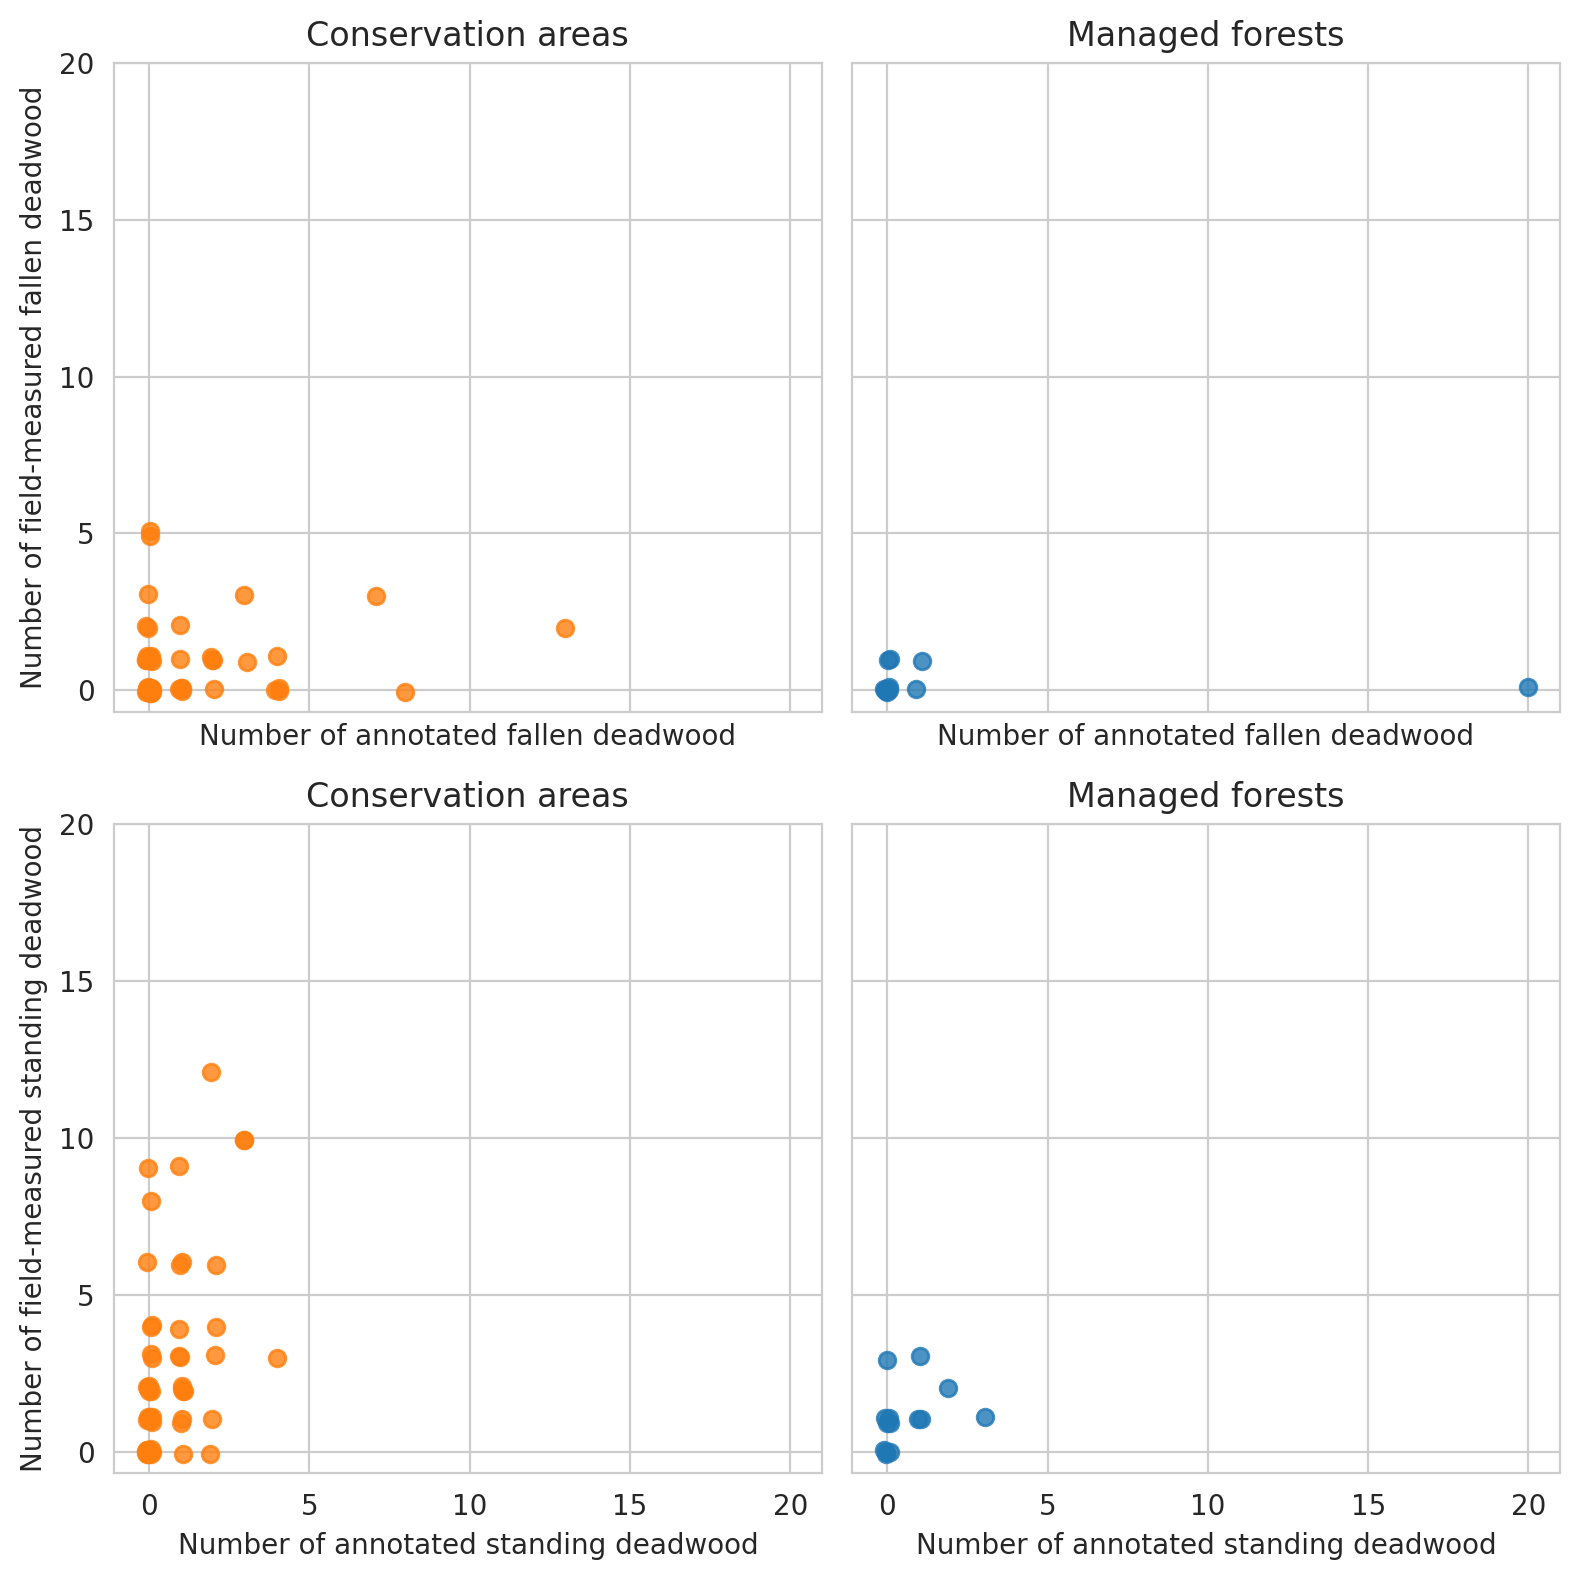

In [71]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
plt.tight_layout()
plt.savefig('../data/figures/evo_dist.jpeg', dpi=300, bbox_inches='tight')

In [72]:
evo_plots['n_ddw_diff'] = evo_plots.n_ddw_plot - evo_plots.n_ddw_ann

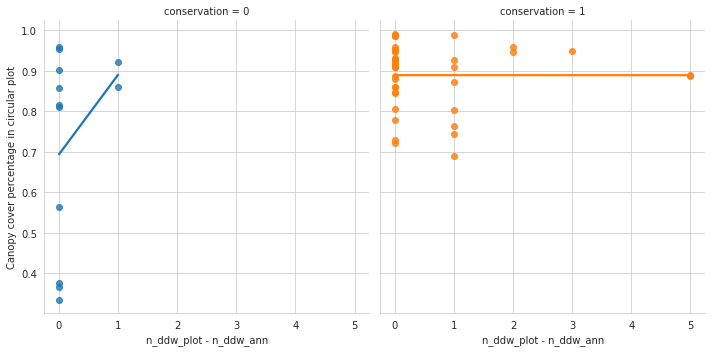

In [73]:
g = sns.lmplot(data=evo_plots[evo_plots.n_ddw_diff >=0], x='n_ddw_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('n_ddw_plot - n_ddw_ann')


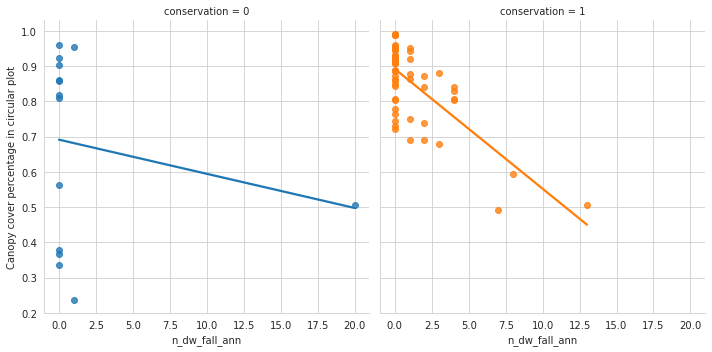

In [74]:
g = sns.lmplot(data=evo_plots, x='n_ddw_ann', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('n_dw_fall_ann')


In [75]:
evo_plots['n_dw_plot_diff'] = evo_plots.n_dw_plot - evo_plots.n_dw_ann

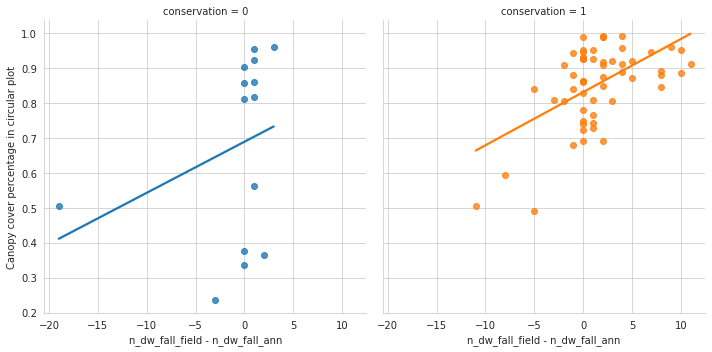

In [76]:
g = sns.lmplot(data=evo_plots, x='n_dw_plot_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('n_dw_fall_field - n_dw_fall_ann')


As Evo data doesn't have field-measured deadwood lengths, we can't plot that relationship. We can, however, plot the DBH distributions, even though Evo dataset only has around 50 downed deadwood with dbh measured.

In [77]:
evo_field_data = evo_field_data[evo_field_data.plotid.isin(evo_plots.id.unique())]

In [78]:
evo_field_data['conservation'] = evo_field_data.apply(lambda row: evo_plots[evo_plots.id == row.plotid].conservation.unique()[0], axis=1)

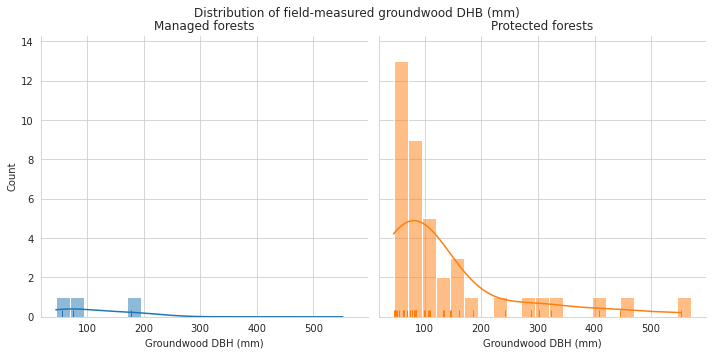

In [79]:
g = sns.displot(data=evo_field_data[(evo_field_data.puuluo == 4)&(evo_field_data.lapimitta_mm>0)], 
                x='lapimitta_mm', hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False, binwidth=25) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood DBH (mm)')
plt.show()

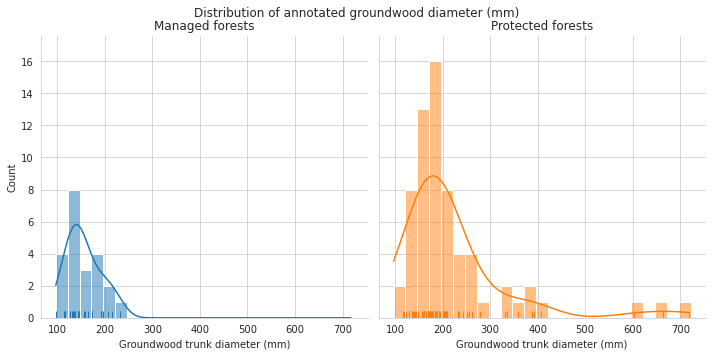

In [80]:
evo_anns['diam'] = evo_anns.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=evo_anns[(evo_anns.label=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, binwidth=25) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk diameter (mm)')
plt.show()

In [92]:
pd.pivot_table(data=evo_field_data[(evo_field_data.puuluo == 4)&(evo_field_data.lapimitta_mm>0)],
               index=['conservation'], values=['est_pituus_m', 'lapimitta_mm'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean                       min                       max  \
             est_pituus_m lapimitta_mm est_pituus_m lapimitta_mm est_pituus_m   
conservation                                                                    
0               11.681000   102.666667        8.129           56       16.609   
1               12.518900   135.600000        5.446           45       34.211   
All             12.460442   133.302326        5.446           45       34.211   

                           
             lapimitta_mm  
conservation               
0                     177  
1                     552  
All                   552

In [82]:
evo_anns['tree_length'] = evo_anns.geometry.apply(get_len)

In [91]:
pd.pivot_table(data=evo_anns[evo_anns.label=='groundwood'], index=['conservation'], values=['tree_length', 'diam'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean                     min                     max  \
                    diam tree_length        diam tree_length        diam   
conservation                                                               
0             155.166198    1.685594   96.973814    0.605847  232.295160   
1             222.995232    4.247291  116.667800    1.164928  717.544431   
All           205.843063    3.599506   96.973814    0.605847  717.544431   

                          
             tree_length  
conservation              
0               3.756445  
1              17.731423  
All            17.731423

Volume estimations for Evo data are really inaccurate, as most field data measurements are zero.

In [84]:
evo_anns['v_ddw'] = evo_anns.geometry.apply(cut_cone_volume)
evo_plots['v_ddw_ann'] = evo_plots.apply(lambda row: evo_anns[(evo_anns.plot_id == row.id) &
                                                              (evo_anns.label == 'groundwood')
                                                              ].v_ddw.sum()
                                              , axis=1)

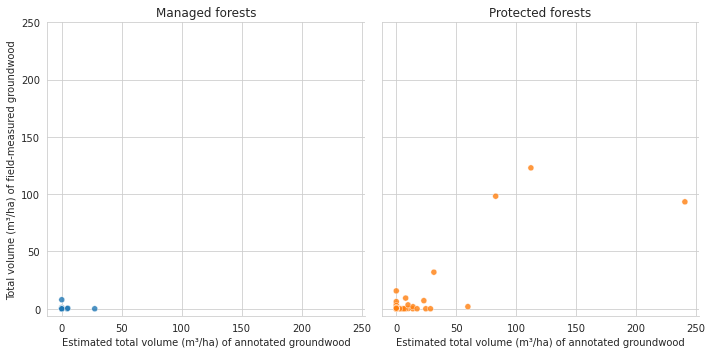

In [85]:
evo_plots['v_ddw_ann_ha'] = (10000 * evo_plots.v_ddw_ann) / (np.pi * 9**2)
g = sns.relplot(data=evo_plots, x='v_ddw_ann_ha', y='v_ddw', col='conservation', hue='conservation', alpha=.8,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(range(0,251,50))
g.axes[0,0].set_xticks(range(0,251,50))
g.axes[0,1].set_xticks(range(0,251,50))
g.set_ylabels('Total volume (m³/ha) of field-measured groundwood')
g.set_xlabels('Estimated total volume (m³/ha) of annotated groundwood')
plt.show()

In [86]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw
conservation,,,,,,
0,0.0,7.873780,0.661535,0.0,2.094276,14
1,0.0,123.004587,7.131762,0.0,23.939949,57
All,0.0,123.004587,5.855943,0.0,21.587804,71


In [87]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw_ann_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha
conservation,,,,,,
0,0.0,27.490278,2.644301,0.0,7.355574,14
1,0.0,240.684389,12.333702,0.0,36.917861,57
All,0.0,240.684389,10.423116,0.0,33.398580,71
